# LIP Reconstruction

This notebook requires:
* a Python 2 kernel
* installation of pygplates
    * pygplates documentation can be found here: https://www.gplates.org/docs/pygplates/
    * specific for features: http://www.gplates.org/docs/pygplates/generated/pygplates.Feature.html
    * specific for reconstructed feature geometries: https://www.gplates.org/docs/pygplates/generated/pygplates.ReconstructedFeatureGeometry.html#pygplates.ReconstructedFeatureGeometry
* installation of cartopy: `conda install cartopy`

## Modules

In [1]:
import sys
sys.version_info

sys.version_info(major=2, minor=7, micro=15, releaselevel='final', serial=0)

In [2]:
import numpy as np
from numpy.core.umath_tests import inner1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import pygplates

import cartopy
import cartopy.crs as ccrs
from shapely.geometry.polygon import Polygon

from tqdm import tqdm_notebook

from netCDF4 import Dataset

/Users/yuempark/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  


In [3]:
from recon_tools import lat_lon_2_cart
from recon_tools import cart_2_lat_lon
from recon_tools import fast_cross
from recon_tools import cross_and_normalize
from recon_tools import intersection
from recon_tools import check_polygon_in_band
from recon_tools import get_area_in_band
from recon_tools import get_areas_in_bands
from recon_tools import get_length_in_band
from recon_tools import get_lengths_in_bands
from recon_tools import plot_reconstruction
from recon_tools import plot_polygons

## Functions

In [4]:
def initialize_LIP_dict(LIP_feature_collection, ignore_age):
    """
    Initialize the dictionary which contains the LIP fraction remaining for all LIPs.

    Parameters
    ----------
    LIP_feature_collection : feature collection
        feature collection of LIPs
    ignore_age : float
        set frac to 0 for all LIPs older than this age
    
    Returns
    -------
    LIP_fracs : dictionary
        with keys = LIP Ids, values = LIP fraction remaining
    """
    # get the unique ID associated with each LIP geometry
    LIP_Ids = []
    LIP_values = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)

        LIP_begin, LIP_end = feature.get_valid_time()
        if LIP_begin > ignore_age:
            LIP_values.append(0)
        else:
            LIP_values.append(1)
        
    # create a dictionary: key = LIP Id, value = LIP fraction remaining
    LIP_fracs = dict(zip(LIP_Ids, LIP_values))

    return LIP_fracs

In [5]:
def get_LIP_areas_in_bands(reconstructed_feature_geometries, lat_mins, lat_maxs,
                           thresh, halflife, cover_thresh, cover_halflife):
    """
    Get the area of all features in each latitude band, with optional calculations for:
    - features instantly disappearing after `thresh` years
    - features decaying exponentially
    - covered features instantly disappearing after `cover_thresh` years, and other features
      decaying exponentially

    Parameters
    ----------
    reconstructed_feature_geometries : list
        list of reconstructed features
    lat_mins : array-like
        array-like of latitude minimums
    lat_maxs : array_like
        array_like of latitude maximums
    thresh : array-like
        after this many Myrs, the feature will instantly disappear
    halflife : array-like
        half life of exponential decay
    cover_thresh : float
        after this many Myrs, the covered feature will instantly disappear
    cover_halflife : array-like
        halflife of the uncovered features

    Returns
    -------
    areas : array
        list of total area in each latitude band
    area_polygons : list
        list of all polygons for which areas were calculated
    areas_thresh : list of arrays
        list of total area in each latitude band, accounting for thresholding method
    areas_decay : list of arrays
        list of total area in each latitude band, accounting for exponential decay method
    areas_cover : list of arrays
        list of total area in each latitude band, accounting for cover method
    """
    # storage vectors
    areas = np.array([])
    area_polygons = []

    areas_thresh_temp = []
    
    areas_decay_temp = []
    # convert halflife to decay constant
    lamb = np.log(2)/halflife
    
    areas_cover_temp = []
    cover_lamb = np.log(2)/cover_halflife

    # iterate over each latitude band
    for i in range(len(lat_mins)):

        accumulated_area = 0

        accumulated_area_thresh = np.zeros(len(thresh))
        accumulated_area_decay = np.zeros(len(halflife))
        accumulated_area_cover = np.zeros(len(cover_halflife))

        # iterate over each polygon
        for j in range(len(reconstructed_feature_geometries)):

            # get the begin date, reconstruction date, and feature age
            begin_date, end_date = reconstructed_feature_geometries[j].get_feature().get_valid_time()
            now_date = reconstructed_feature_geometries[j].get_reconstruction_time()
            feature_age = begin_date - now_date
            feature_name = reconstructed_feature_geometries[j].get_feature().get_name()
            feature_Id = reconstructed_feature_geometries[j].get_feature().get_feature_id().get_string()

            # get the actual polygon
            current_polygon = reconstructed_feature_geometries[j].get_reconstructed_geometry()

            # check if the polygon is in the band
            in_band = check_polygon_in_band(current_polygon, lat_mins[i], lat_maxs[i])

            if in_band:
                # do the calculation
                area, band_polygon = get_area_in_band(current_polygon, lat_mins[i], lat_maxs[i])

                # store results
                if begin_date<=520:
                    accumulated_area = accumulated_area + area
                area_polygons.append(band_polygon)

                # threshold method
                for k in range(len(thresh)):
                    # check if the polygon is past its due by date
                    if begin_date < (now_date+thresh[k]):
                        still_alive = True
                    else:
                        still_alive = False

                    if still_alive:
                        accumulated_area_thresh[k] = accumulated_area_thresh[k] + area

                # decay method
                for k in range(len(halflife)):
                    # scale the area based on the exponential decay equation
                    decay_area = area * np.exp(-lamb[k]*feature_age)

                    # store results
                    accumulated_area_decay[k] = accumulated_area_decay[k] + decay_area
                        
                # cover method
                if feature_name in covered_LIP_names:
                    for k in range(len(cover_halflife)):
                        # check if the polygon is past its due by date
                        if begin_date < (now_date+cover_thresh):
                            still_alive = True
                        else:
                            still_alive = False

                        if still_alive:
                            accumulated_area_cover[k] = accumulated_area_cover[k] + area
                else:
                    for k in range(len(cover_halflife)):
                        # scale the area based on the exponential decay equation
                        decay_area = area * np.exp(-cover_lamb[k]*feature_age)

                        # store results
                        accumulated_area_cover[k] = accumulated_area_cover[k] + decay_area
                        
        # store total area for the band
        areas = np.append(areas, accumulated_area)

        areas_thresh_temp.append(accumulated_area_thresh)
        areas_decay_temp.append(accumulated_area_decay)
        areas_cover_temp.append(accumulated_area_cover)

    # basically, flip our outputs so that each array in our list is for a given input thresh/halflife
    areas_thresh = []
    for i in range(len(thresh)):
        this_array = np.array([])
        for j in range(len(areas_thresh_temp)):
            this_array = np.append(this_array, areas_thresh_temp[j][i])
        areas_thresh.append(this_array)
    areas_decay = []
    for i in range(len(halflife)):
        this_array = np.array([])
        for j in range(len(areas_decay_temp)):
            this_array = np.append(this_array, areas_decay_temp[j][i])
        areas_decay.append(this_array)
    areas_cover = []
    for i in range(len(cover_halflife)):
        this_array = np.array([])
        for j in range(len(areas_cover_temp)):
            this_array = np.append(this_array, areas_cover_temp[j][i])
        areas_cover.append(this_array)

    # returns
    return areas, area_polygons, areas_thresh, areas_decay, areas_cover

## Read In Files

In [6]:
# change this root to the dropbox folder
root = '/Users/yuempark/Dropbox/Ophiolite_Compilation/'

LIP_feature_collection = pygplates.FeatureCollection.read(root+'Paleogeo_models/LIPs_current/Ernst_lipshapefiles/LIP_Outline_edited.shp')
craton_feature_collection = pygplates.FeatureCollection.read(root+'Paleogeo_models/CEED6/CEED6_POLY.shp')
model = root+'Paleogeo_models/TC2017_SHM2017_D2018.rot'

In [7]:
ice = pd.read_csv('../Data/Ice_Extent.csv')

## Testing

In [8]:
# create the latitude bands
# band_width must be a factor of 90
band_width = 5
lat_mins = np.arange(-90           , 90           , band_width)
lat_maxs = np.arange(-90+band_width, 90+band_width, band_width)
lat_mids = lat_mins + (lat_maxs-lat_mins)/2

In [9]:
# input parameters
t = 40     #reconstruction time
anchor = 1  #anchor plate ID

# carry out the reconstruction for the cratons
reconstructed_cratons = []
pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, t, anchor)

# carry out the reconstruction for the LIPs
reconstructed_LIPs = []
pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, t, anchor)

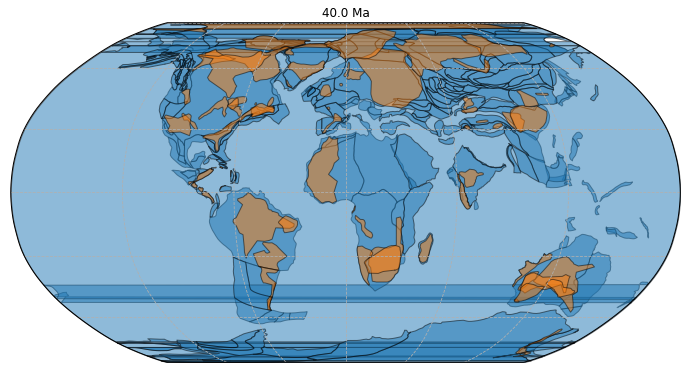

In [10]:
plot_reconstruction([reconstructed_cratons, reconstructed_LIPs], ['C0','C1'], lon_0=0)

In [11]:
# perform the calculations for cratons
areas_cratons, area_polygons_cratons = get_areas_in_bands(reconstructed_cratons, lat_mins, lat_maxs)

# perform the calculations for LIPs
areas_LIPs, area_polygons_LIPs = get_areas_in_bands(reconstructed_LIPs, lat_mins, lat_maxs)

In [12]:
#plot_polygons(area_polygons_cratons, 'C0', lon_0=0)

In [13]:
#plot_polygons(area_polygons_LIPs, 'C1', lon_0=0)

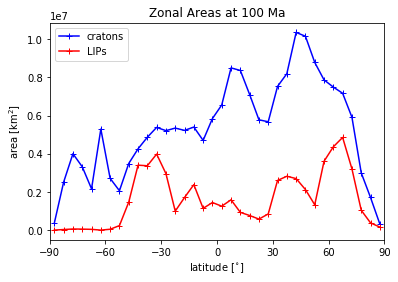

In [14]:
cols = ['area_km2','minimum_latitude','maximum_latitude']

df_cratons = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_cratons})
df_cratons = df_cratons[cols]

df_LIPs = pd.DataFrame({'minimum_latitude':lat_mins, 'maximum_latitude':lat_maxs, 'area_km2':areas_LIPs})
df_LIPs = df_LIPs[cols]

fig, ax = plt.subplots()
ax.plot((df_cratons['minimum_latitude']+(df_cratons['maximum_latitude']-df_cratons['minimum_latitude'])/2), \
        df_cratons['area_km2'], 'b+-', label='cratons')
ax.plot((df_LIPs['minimum_latitude']+(df_LIPs['maximum_latitude']-df_LIPs['minimum_latitude'])/2), \
        df_LIPs['area_km2'], 'r+-', label='LIPs')
ax.set_xlabel('latitude [$^{\circ}$]')
ax.set_ylabel('area [km$^{2}$]')
ax.set_xlim(-90,90)
ax.set_xticks([-90,-60,-30,0,30,60,90])
ax.set_title('Zonal Areas at 100 Ma')
ax.legend()
plt.show(fig)

Reality check - relative to area of exposed land (Coble et al., 1987):

In [15]:
np.sum(df_cratons['area_km2'])/148.3e6

1.2989021840856936

Reality check - relative to total area of continental crust (Cogley, 1984):

In [16]:
np.sum(df_cratons['area_km2'])/2.1e8

0.9172723519043255

## Calculations

The TC2017 model applies from 550Ma onwards.

### Calculation Set Up

In [17]:
# time resolution
t_step = -5

# anchor plate ID
anchor = 1

# set up the time vector
t_start = 545
t_stop = 0
ts = np.arange(t_start, t_stop+t_step, t_step)

# the threshold for LIP death
thresh = [50, 150, 300]

# the halflife for exponential decay
halflife = [36, 100, 200]

# the halflife for exponential decay
cover_thresh = 5
cover_halflife = [36, 100, 200]

# some assumptions of LIP characteristics
thickness = 2      #km
density = 2.8e12   #kg/km^3

# the LIP fraction remaining dictionary
LIP_fracs = initialize_LIP_dict(LIP_feature_collection, 550)

Note: every time the shapefile is read in, pygplates assigns a new set of unique IDs to the features - however, the order that the features are read in remains the same.

In [18]:
# the previous version
#covered_LIP_names = ['Parana-Etendeka',
#                     'CAMP',
#                     'Wichita',
#                     'NAIP',
#                     'Madagascar',
#                     'Maud Rise',
#                     'Seychelles',
#                     'NW-Australian margin']

# new version
covered_LIP_names = ['Wichita',
                     'CAMP',
                     'NW Australia Margin',
                     'Parana-Etendeka',
                     'Seychelles',
                     'North Atlantic']

silicic_LIP_names = ['Sierra Madre Occidental',
                     'Whitsunday',
                     'Chon Aike',
                     'Kennedy-Conners-Auburn',
                     'Ouarzazate']

### Perform Calculations

The calculations take some time to perform - let's save them to a .csv so we only have to recalculate when we want to change something in the calculations:

In [19]:
refresh = False

if refresh:
    # get the unique ID and name associated with each LIP geometry
    LIP_Ids = []
    LIP_names = []
    LIP_begins = []
    LIP_areas = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)
        LIP_name = feature.get_name()
        LIP_names.append(LIP_name)
        LIP_begin, LIP_end = feature.get_valid_time()
        LIP_begins.append(LIP_begin)
        LIP_area = feature.get_geometry().get_area() * 6371.009**2
        LIP_areas.append(LIP_area)
    LIP_properties = pd.DataFrame({'Ids':LIP_Ids,'names':LIP_names,'begins':LIP_begins,'areas':LIP_areas})
    
    # initialize storage dataframes
    areas_cratons_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    
    areas_LIPs_thresh1_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_thresh2_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_thresh3_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    
    areas_LIPs_decay1_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_decay2_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_decay3_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    
    areas_LIPs_cover1_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover2_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    areas_LIPs_cover3_df = pd.DataFrame({'lat_mins':lat_mins, 'lat_maxs':lat_maxs, 'lat_mids':lat_mids})
    
    centroid_lat_LIPs_df = pd.DataFrame({'LIP_Ids':LIP_Ids,'LIP_names':LIP_names})
    centroid_lon_LIPs_df = pd.DataFrame({'LIP_Ids':LIP_Ids,'LIP_names':LIP_names})

    # iterate through the time vector
    for i in tqdm_notebook(range(len(ts))):

        # carry out the reconstruction
        reconstructed_cratons = []
        pygplates.reconstruct(craton_feature_collection, model, reconstructed_cratons, ts[i], anchor)
        reconstructed_LIPs = []
        pygplates.reconstruct(LIP_feature_collection, model, reconstructed_LIPs, ts[i], anchor)

        # perform the area calculations
        areas_cratons, area_polygons_cratons = get_areas_in_bands(reconstructed_cratons, lat_mins, lat_maxs)
        
        areas_LIPs,area_polygons_LIPs,areas_LIPs_thresh,areas_LIPs_decay,areas_LIPs_cover =\
            get_LIP_areas_in_bands(reconstructed_LIPs,lat_mins,lat_maxs,
                                   thresh,halflife,cover_thresh,cover_halflife)

        # store results
        areas_cratons_df['area_km2_' + str(ts[i])] = areas_cratons
        areas_LIPs_df['area_km2_' + str(ts[i])] = areas_LIPs
        areas_LIPs_thresh1_df['area_km2_' + str(ts[i])] = areas_LIPs_thresh[0]
        areas_LIPs_thresh2_df['area_km2_' + str(ts[i])] = areas_LIPs_thresh[1]
        areas_LIPs_thresh3_df['area_km2_' + str(ts[i])] = areas_LIPs_thresh[2]
        areas_LIPs_decay1_df['area_km2_' + str(ts[i])] = areas_LIPs_decay[0]
        areas_LIPs_decay2_df['area_km2_' + str(ts[i])] = areas_LIPs_decay[1]
        areas_LIPs_decay3_df['area_km2_' + str(ts[i])] = areas_LIPs_decay[2]
        areas_LIPs_cover1_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[0]
        areas_LIPs_cover2_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[1]
        areas_LIPs_cover3_df['area_km2_' + str(ts[i])] = areas_LIPs_cover[2]
        
        # get centroids
        for j in range(len(reconstructed_LIPs)):
            LIP_Id = reconstructed_LIPs[j].get_feature().get_feature_id().get_string()
            current_LIP = reconstructed_LIPs[j].get_reconstructed_geometry()
            centroid_point = current_LIP.get_interior_centroid()
            centroid_lat = centroid_point.to_lat_lon_array()[0][0]
            centroid_lon = centroid_point.to_lat_lon_array()[0][1]
            
            # store
            for k in range(len(centroid_lat_LIPs_df.index)):
                if centroid_lat_LIPs_df['LIP_Ids'][k] == LIP_Id:
                    centroid_lat_LIPs_df.loc[k,'lat_' + str(ts[i])] = centroid_lat
                    centroid_lon_LIPs_df.loc[k,'lon_' + str(ts[i])] = centroid_lon
                    break
        
    # save results to csv's    
    areas_cratons_df.to_csv('reconstruction_output/areas_cratons_df.csv', index=False)
    areas_LIPs_df.to_csv('reconstruction_output/areas_LIPs_df.csv', index=False)
    areas_LIPs_thresh1_df.to_csv('reconstruction_output/areas_LIPs_thresh1_df.csv', index=False)
    areas_LIPs_thresh2_df.to_csv('reconstruction_output/areas_LIPs_thresh2_df.csv', index=False)
    areas_LIPs_thresh3_df.to_csv('reconstruction_output/areas_LIPs_thresh3_df.csv', index=False)
    areas_LIPs_decay1_df.to_csv('reconstruction_output/areas_LIPs_decay1_df.csv', index=False)
    areas_LIPs_decay2_df.to_csv('reconstruction_output/areas_LIPs_decay2_df.csv', index=False)
    areas_LIPs_decay3_df.to_csv('reconstruction_output/areas_LIPs_decay3_df.csv', index=False)
    areas_LIPs_cover1_df.to_csv('reconstruction_output/areas_LIPs_cover1_df.csv', index=False)
    areas_LIPs_cover2_df.to_csv('reconstruction_output/areas_LIPs_cover2_df.csv', index=False)
    areas_LIPs_cover3_df.to_csv('reconstruction_output/areas_LIPs_cover3_df.csv', index=False)
    centroid_lat_LIPs_df.to_csv('reconstruction_output/centroid_lat_LIPs_df.csv', index=False)
    centroid_lon_LIPs_df.to_csv('reconstruction_output/centroid_lon_LIPs_df.csv', index=False)
    LIP_properties.to_csv('reconstruction_output/LIP_properties.csv', index=False)
    
else:
    areas_cratons_df = pd.read_csv('reconstruction_output/areas_cratons_df.csv')
    areas_LIPs_df = pd.read_csv('reconstruction_output/areas_LIPs_df.csv')
    areas_LIPs_thresh1_df = pd.read_csv('reconstruction_output/areas_LIPs_thresh1_df.csv')
    areas_LIPs_thresh2_df = pd.read_csv('reconstruction_output/areas_LIPs_thresh2_df.csv')
    areas_LIPs_thresh3_df = pd.read_csv('reconstruction_output/areas_LIPs_thresh3_df.csv')
    areas_LIPs_decay1_df = pd.read_csv('reconstruction_output/areas_LIPs_decay1_df.csv')
    areas_LIPs_decay2_df = pd.read_csv('reconstruction_output/areas_LIPs_decay2_df.csv')
    areas_LIPs_decay3_df = pd.read_csv('reconstruction_output/areas_LIPs_decay3_df.csv')
    areas_LIPs_cover1_df = pd.read_csv('reconstruction_output/areas_LIPs_cover1_df.csv')
    areas_LIPs_cover2_df = pd.read_csv('reconstruction_output/areas_LIPs_cover2_df.csv')
    areas_LIPs_cover3_df = pd.read_csv('reconstruction_output/areas_LIPs_cover3_df.csv')
    centroid_lat_LIPs_df = pd.read_csv('reconstruction_output/centroid_lat_LIPs_df.csv')
    centroid_lon_LIPs_df = pd.read_csv('reconstruction_output/centroid_lon_LIPs_df.csv')
    LIP_properties = pd.read_csv('reconstruction_output/LIP_properties.csv')
    
    # get the unique ID and name associated with each LIP geometry
    LIP_Ids = []
    for feature in LIP_feature_collection:
        LIP_Id = feature.get_feature_id().get_string()
        LIP_Ids.append(LIP_Id)
        
    # assign the new feature IDs to the old data:
    centroid_lat_LIPs_df['LIP_Ids'] = LIP_Ids
    centroid_lon_LIPs_df['LIP_Ids'] = LIP_Ids
    
    LIP_properties['Ids'] = LIP_Ids
    
    print('CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.')

recon_tools.py:289: RuntimeWarning: invalid value encountered in less
  mask = np.less(new_lats, lat_max+0.1)


In [20]:
if refresh:
    # initiate a new dataframe for absolute latitudes
    num_bands = len(areas_cratons_df.index)

    abs_areas_cratons_df = pd.DataFrame({'lat_maxs':areas_cratons_df['lat_maxs'][(num_bands/2):],
                                         'lat_mids':areas_cratons_df['lat_mids'][(num_bands/2):],
                                         'lat_mins':areas_cratons_df['lat_mins'][(num_bands/2):]})
    abs_areas_cratons_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_df = pd.DataFrame({'lat_maxs':areas_LIPs_df['lat_maxs'][(num_bands/2):],
                                      'lat_mids':areas_LIPs_df['lat_mids'][(num_bands/2):],
                                      'lat_mins':areas_LIPs_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_thresh1_df = pd.DataFrame({'lat_maxs':areas_LIPs_thresh1_df['lat_maxs'][(num_bands/2):],
                                              'lat_mids':areas_LIPs_thresh1_df['lat_mids'][(num_bands/2):],
                                              'lat_mins':areas_LIPs_thresh1_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_thresh1_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_thresh2_df = pd.DataFrame({'lat_maxs':areas_LIPs_thresh2_df['lat_maxs'][(num_bands/2):],
                                              'lat_mids':areas_LIPs_thresh2_df['lat_mids'][(num_bands/2):],
                                              'lat_mins':areas_LIPs_thresh2_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_thresh2_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_thresh3_df = pd.DataFrame({'lat_maxs':areas_LIPs_thresh3_df['lat_maxs'][(num_bands/2):],
                                              'lat_mids':areas_LIPs_thresh3_df['lat_mids'][(num_bands/2):],
                                              'lat_mins':areas_LIPs_thresh3_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_thresh3_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_decay1_df = pd.DataFrame({'lat_maxs':areas_LIPs_decay1_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_decay1_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_decay1_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_decay1_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_decay2_df = pd.DataFrame({'lat_maxs':areas_LIPs_decay2_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_decay2_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_decay2_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_decay2_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_decay3_df = pd.DataFrame({'lat_maxs':areas_LIPs_decay3_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_decay3_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_decay3_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_decay3_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover1_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover1_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover1_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover1_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover1_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover2_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover2_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover2_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover2_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover2_df.reset_index(drop=True, inplace=True)

    abs_areas_LIPs_cover3_df = pd.DataFrame({'lat_maxs':areas_LIPs_cover3_df['lat_maxs'][(num_bands/2):],
                                             'lat_mids':areas_LIPs_cover3_df['lat_mids'][(num_bands/2):],
                                             'lat_mins':areas_LIPs_cover3_df['lat_mins'][(num_bands/2):]})
    abs_areas_LIPs_cover3_df.reset_index(drop=True, inplace=True)

    # iterate over the time steps
    for i in tqdm_notebook(range(len(ts))):
        # iterate over the bands: sum then store
        for j in range(num_bands/2):
            abs_area = areas_cratons_df['area_km2_'+str(ts[i])][j]+\
                       areas_cratons_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_cratons_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_thresh1_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_thresh1_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_thresh1_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_thresh2_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_thresh2_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_thresh2_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_thresh3_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_thresh3_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_thresh3_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_decay1_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_decay1_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_decay1_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_decay2_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_decay2_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_decay2_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_decay3_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_decay3_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_decay3_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover1_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover1_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover1_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover2_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover2_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover2_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area

            abs_area = areas_LIPs_cover3_df['area_km2_'+str(ts[i])][j]+\
                       areas_LIPs_cover3_df['area_km2_'+str(ts[i])][(num_bands-1)-j]
            abs_areas_LIPs_cover3_df.loc[((num_bands/2)-1)-j,'area_km2_'+str(ts[i])]=abs_area
            
    # save results to csv's    
    abs_areas_cratons_df.to_csv('reconstruction_output/abs_areas_cratons_df.csv', index=False)
    abs_areas_LIPs_df.to_csv('reconstruction_output/abs_areas_LIPs_df.csv', index=False)
    abs_areas_LIPs_thresh1_df.to_csv('reconstruction_output/abs_areas_LIPs_thresh1_df.csv', index=False)
    abs_areas_LIPs_thresh2_df.to_csv('reconstruction_output/abs_areas_LIPs_thresh2_df.csv', index=False)
    abs_areas_LIPs_thresh3_df.to_csv('reconstruction_output/abs_areas_LIPs_thresh3_df.csv', index=False)
    abs_areas_LIPs_decay1_df.to_csv('reconstruction_output/abs_areas_LIPs_decay1_df.csv', index=False)
    abs_areas_LIPs_decay2_df.to_csv('reconstruction_output/abs_areas_LIPs_decay2_df.csv', index=False)
    abs_areas_LIPs_decay3_df.to_csv('reconstruction_output/abs_areas_LIPs_decay3_df.csv', index=False)
    abs_areas_LIPs_cover1_df.to_csv('reconstruction_output/abs_areas_LIPs_cover1_df.csv', index=False)
    abs_areas_LIPs_cover2_df.to_csv('reconstruction_output/abs_areas_LIPs_cover2_df.csv', index=False)
    abs_areas_LIPs_cover3_df.to_csv('reconstruction_output/abs_areas_LIPs_cover3_df.csv', index=False)
    
else:
    abs_areas_cratons_df = pd.read_csv('reconstruction_output/abs_areas_cratons_df.csv')
    abs_areas_LIPs_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_df.csv')
    abs_areas_LIPs_thresh1_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_thresh1_df.csv')
    abs_areas_LIPs_thresh2_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_thresh2_df.csv')
    abs_areas_LIPs_thresh3_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_thresh3_df.csv')
    abs_areas_LIPs_decay1_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_decay1_df.csv')
    abs_areas_LIPs_decay2_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_decay2_df.csv')
    abs_areas_LIPs_decay3_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_decay3_df.csv')
    abs_areas_LIPs_cover1_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover1_df.csv')
    abs_areas_LIPs_cover2_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover2_df.csv')
    abs_areas_LIPs_cover3_df = pd.read_csv('reconstruction_output/abs_areas_LIPs_cover3_df.csv')
    
    print('CALCULATIONS NOT PERFORMED: PREVIOUS RESULTS READ IN.')

### Total Area

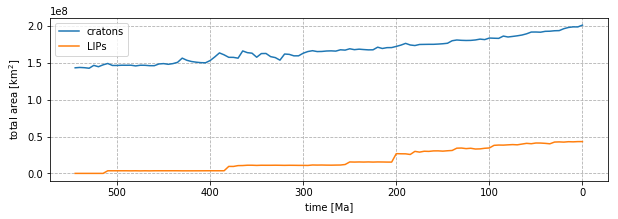

In [21]:
# calculate the total area at each time step
total_area_cratons = []
for i in range(len(ts)):
    area = sum(areas_cratons_df['area_km2_' + str(ts[i])])
    total_area_cratons.append(area)
    
total_area_LIPs = []
for i in range(len(ts)):
    area = sum(areas_LIPs_df['area_km2_' + str(ts[i])])
    total_area_LIPs.append(area)
    
# plot
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(ts, total_area_cratons, c='C0', label='cratons')
ax.plot(ts, total_area_LIPs, c='C1', label='LIPs')
ax.set_ylabel('total area [km$^{2}$]')
ax.set_xlabel('time [Ma]')
ax.legend()
ax.invert_xaxis()
ax.grid(ls='--')
plt.show(fig)

### Zonal Distribution

In [22]:
def plot_contourf(df):
    fig, ax = plt.subplots(figsize=(16,5))

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax.contourf(ts, df['lat_mids'], just_values, cmap='magma', levels=levels)

    ax.set_ylabel('latitude [$^{\circ}$]')
    ax.set_yticks([-90,-45,0,45,90])

    ax.set_xlabel('age [Ma]')
    ax.invert_xaxis()

    cbar = fig.colorbar(cntrf, ax=ax)
    cbar.ax.set_ylabel('area [km$^{2}$]')

    plt.show(fig)

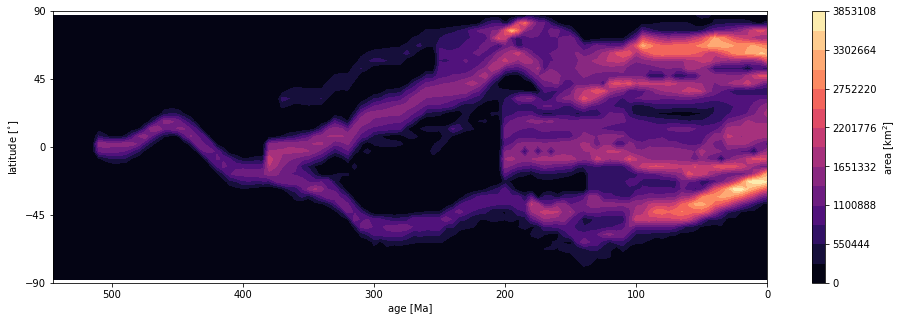

In [23]:
plot_contourf(areas_LIPs_df)

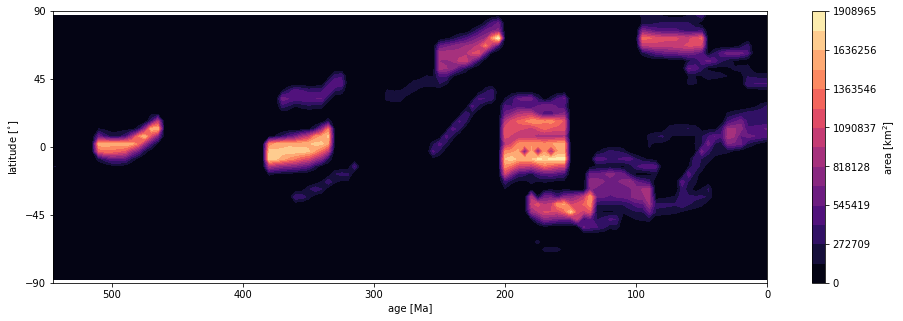

In [24]:
plot_contourf(areas_LIPs_thresh1_df)

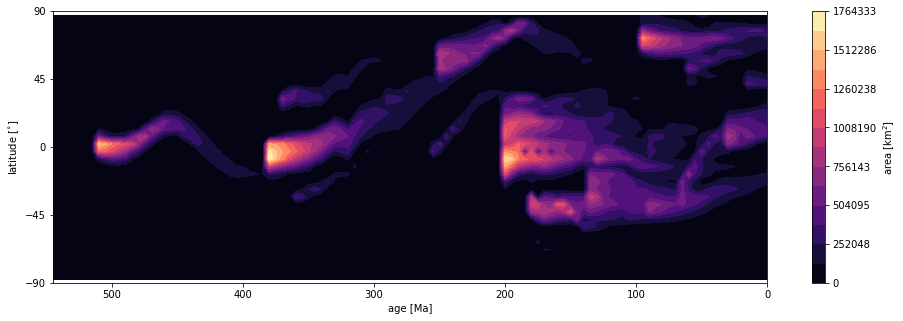

In [25]:
plot_contourf(areas_LIPs_decay1_df)

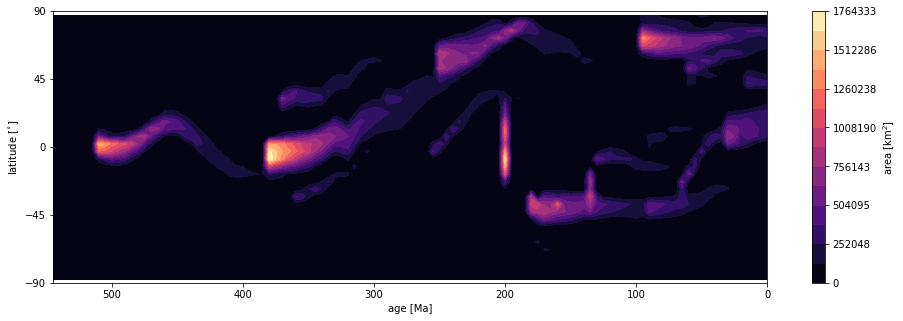

In [26]:
plot_contourf(areas_LIPs_cover1_df)

In [27]:
def plot_abs_contourf(df):
    fig, ax = plt.subplots(figsize=(16,5))

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax.contourf(ts, df['lat_mids'], just_values, cmap='magma', levels=levels)

    ax.set_ylabel('latitude [$^{\circ}$]')
    ax.set_yticks([0,30,60,90])

    ax.set_xlabel('age [Ma]')
    ax.invert_xaxis()

    cbar = fig.colorbar(cntrf, ax=ax)
    cbar.ax.set_ylabel('area [km$^{2}$]')

    plt.show(fig)

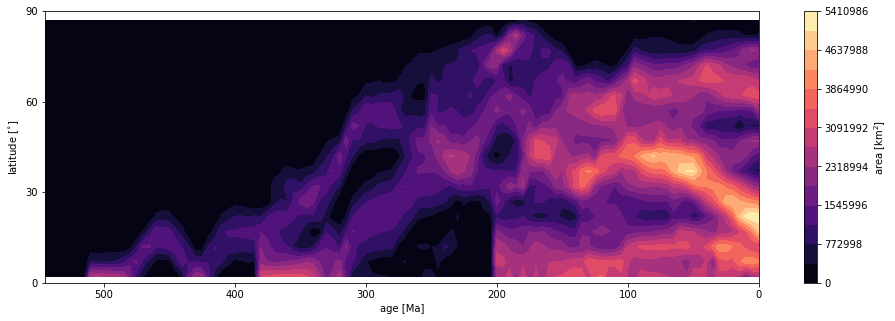

In [28]:
plot_abs_contourf(abs_areas_LIPs_df)

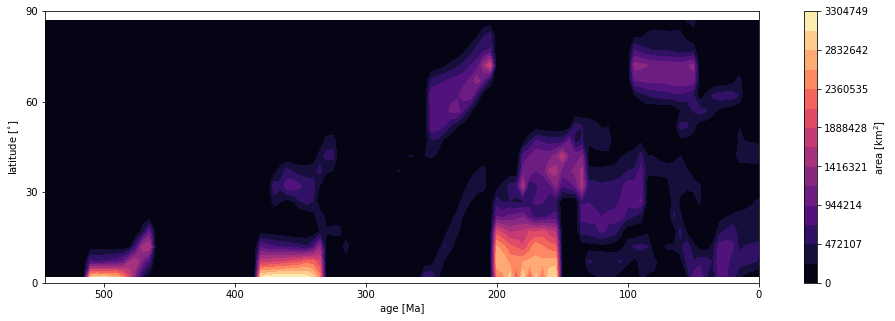

In [29]:
plot_abs_contourf(abs_areas_LIPs_thresh1_df)

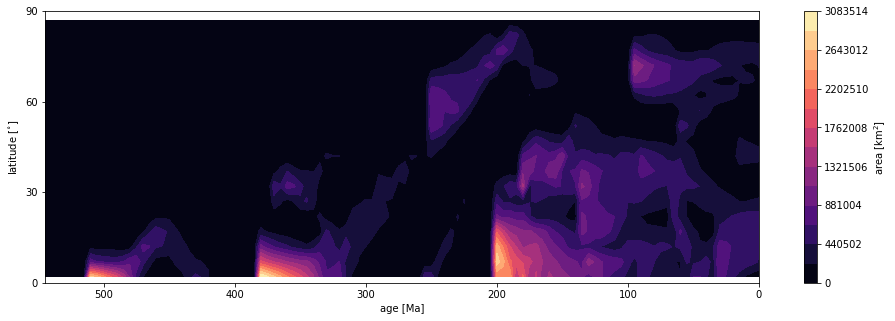

In [30]:
plot_abs_contourf(abs_areas_LIPs_decay1_df)

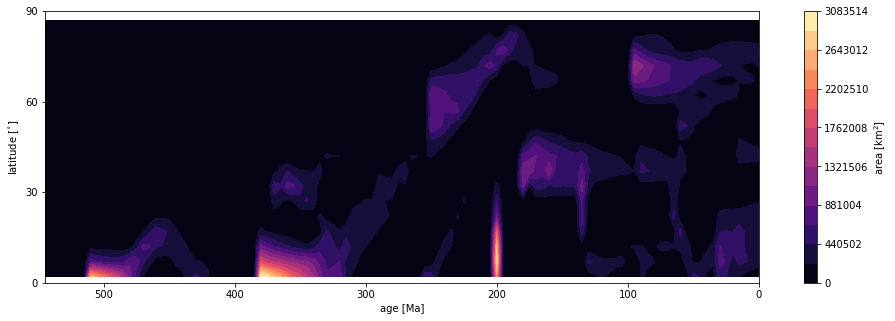

In [31]:
plot_abs_contourf(abs_areas_LIPs_cover1_df)

In [32]:
def plot_abs_contourf(df):
    fig, ax = plt.subplots(figsize=(16,5))

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax.contourf(ts, df['lat_mids'], just_values, cmap='magma', levels=levels)

    ax.set_ylabel('latitude [$^{\circ}$]')
    ax.set_yticks([0,30,60,90])

    ax.set_xlabel('age [Ma]')
    ax.invert_xaxis()

    cbar = fig.colorbar(cntrf, ax=ax)
    cbar.ax.set_ylabel('area [km$^{2}$]')

    plt.show(fig)

In [33]:
def plot_within_eq(df):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), gridspec_kw={'height_ratios':[1,7,7]})

    ##### LINES
    ax[1].plot(ts, df.loc[0][3:],
               c='C0', label='within ' + str(band_width) + '$^{\circ}$ of equator')

    ax[1].plot(ts, df.loc[0][3:]+df.loc[1][3:],
               c='C1', label='within ' + str(band_width*2) + '$^{\circ}$ of equator')

    ax[1].plot(ts, df.loc[0][3:]+df.loc[1][3:]+df.loc[2][3:],
               c='C2', label='within ' + str(band_width*3) + '$^{\circ}$ of equator')

    ax[1].invert_xaxis()
    ax[1].set_ylabel('area [km$^{2}$]')
    ax[1].set_xticklabels([])
    ax[1].legend()
    
    ##### CONTOURF
    ax[2].set_xlim(ax[1].get_xlim())
    ax[2].set_ylim(0,90)
    ax[2].set_yticks([0,30,60,90])
    ax[2].set_xlabel('age [Ma]')
    ax[2].set_ylabel('absolute latitude')

    just_values = df.values[:,3:]

    levels = np.linspace(np.min(just_values),np.max(just_values),15)

    cntrf = ax[2].contourf(ts, df['lat_mids'], just_values, cmap='magma', levels=levels)
    
    cbar_position = fig.add_axes([0.93,0.15,0.02,0.25])

    cbar = fig.colorbar(cntrf, cax=cbar_position)
    cbar.ax.set_ylabel('area [km$^{2}$]')
    
    ##### GLACIAL PATCHES
    ax[0].set_xlim(ax[1].get_xlim())
    ax[0].set_xticklabels([])
    ax[0].set_ylim(0,1)
    ax[0].set_yticks([])

    #Hirnantian glaciation (455 to 435 Ma)
    Hirnantian = patches.Rectangle((435,0),20,1,edgecolor='none',facecolor='#447CC0')
    ax[0].add_patch(Hirnantian)
    #Late Paleozoic ice age (320 to 280 Ma)
    LPIA = patches.Rectangle((280,0),40,1,edgecolor='none',facecolor='#447CC0')
    ax[0].add_patch(LPIA)
    #Cenozoic glaciation (35 to 0 Ma)
    Cenozoic = patches.Rectangle((0,0),35,1,edgecolor='none',facecolor='#447CC0')
    ax[0].add_patch(Cenozoic)
    ax[0].text(ax[1].get_xlim()[0]*1.003,0.5,
               'glacial\nintervals',verticalalignment='center',horizontalalignment='right',color='#447CC0')

    plt.show(fig)

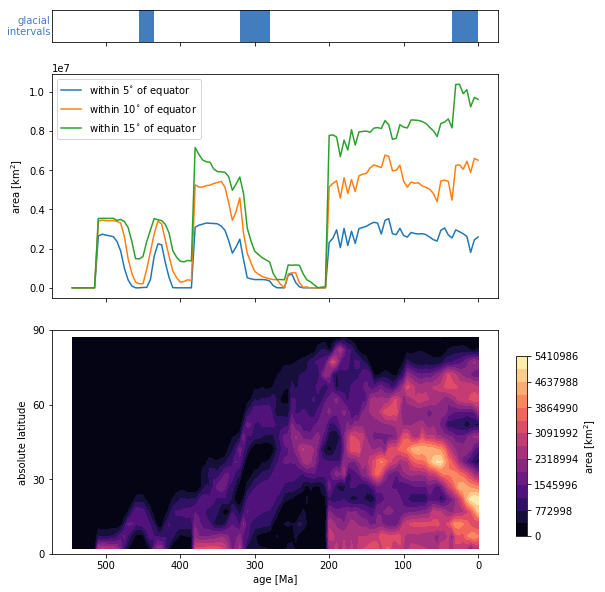

In [34]:
plot_within_eq(abs_areas_LIPs_df)

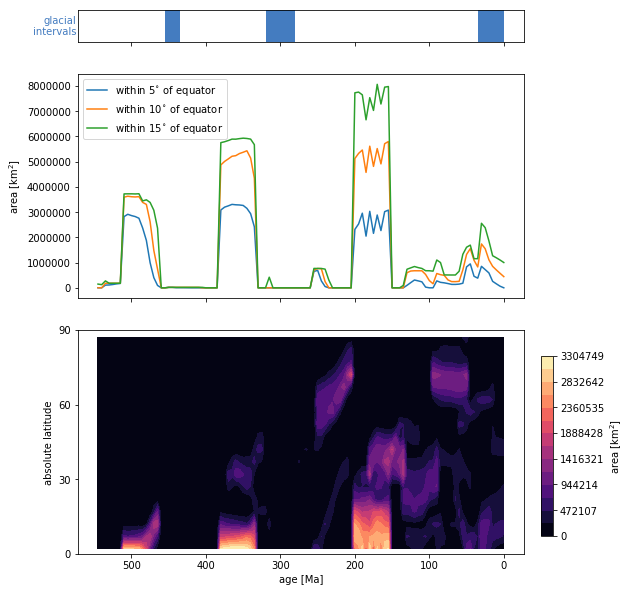

In [35]:
plot_within_eq(abs_areas_LIPs_thresh1_df)

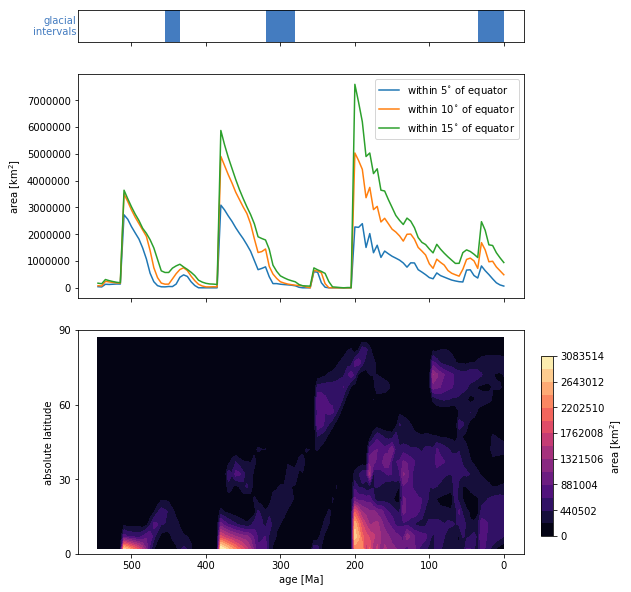

In [36]:
plot_within_eq(abs_areas_LIPs_decay1_df)

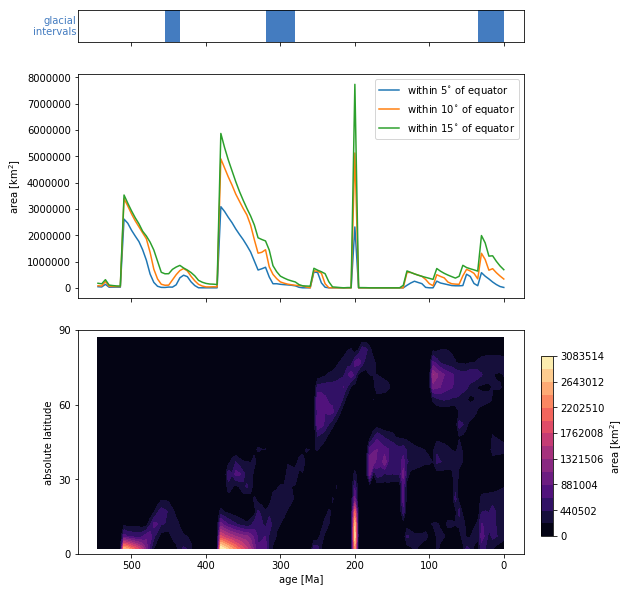

In [37]:
plot_within_eq(abs_areas_LIPs_cover1_df)

### Centroids

In [38]:
emplacement_lat = np.array([])
emplacement_area = np.array([])
emplacement_age = np.array([])

for i in range(len(LIP_properties.index)):
    emplacement_area = np.append(emplacement_area, LIP_properties['areas'][i])
    emplacement_age = np.append(emplacement_age, LIP_properties['begins'][i])
    
    row = centroid_lat_LIPs_df[centroid_lat_LIPs_df['LIP_Ids']==LIP_properties['Ids'][i]].values[0,2:]
    
    for j in range(len(row)):
        if np.isnan(row[j]):
            pass
        else:
            ind = j
            break
    
    emplacement_lat = np.append(emplacement_lat, row[j])

### Figures

In [39]:
print(thresh)
print(halflife)
print(cover_thresh)
print(cover_halflife)

[50, 150, 300]
[36, 100, 200]
5
[36, 100, 200]


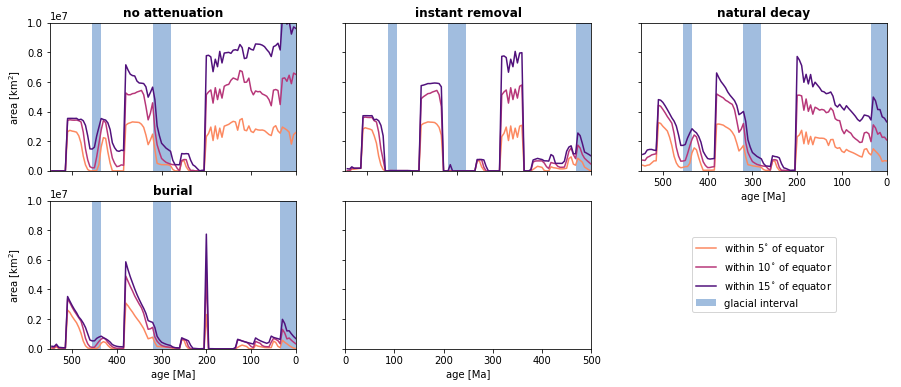

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=3,
                       figsize=(15,6), sharey=True)

ax = ax.flatten()

df_plot = [abs_areas_LIPs_df,
           abs_areas_LIPs_thresh1_df,
           abs_areas_LIPs_decay2_df,
           abs_areas_LIPs_cover1_df]
df_plot_title = ['no attenuation',
                 'instant removal',
                 'natural decay',
                 'burial',
                 'Dessert et al. (2003)']

##### LINES
for i in range(len(df_plot)):
    ax[i].plot(ts, df_plot[i].loc[0][3:],
               c=plt.cm.magma(0.75), label='within ' + str(band_width) + '$^{\circ}$ of equator')
    ax[i].plot(ts, df_plot[i].loc[0][3:]+df_plot[i].loc[1][3:],
               c=plt.cm.magma(0.50), label='within ' + str(band_width*2) + '$^{\circ}$ of equator')
    ax[i].plot(ts, df_plot[i].loc[0][3:]+df_plot[i].loc[1][3:]+df_plot[i].loc[2][3:],
               c=plt.cm.magma(0.25), label='within ' + str(band_width*3) + '$^{\circ}$ of equator')
    ax[i].set_xlim(550,0)
    ax[i].set_xticklabels([])
    ax[i].set_title(df_plot_title[i], fontweight='semibold')

ax[0].set_ylim(0,1e7)

ax[0].set_ylabel('area [km$^{2}$]')
ax[3].set_ylabel('area [km$^{2}$]')

ax[3].set_xticklabels([0,100,200,300,400,500])
ax[3].set_xlabel('age [Ma]')
ax[4].set_xticklabels([0,100,200,300,400,500])
ax[4].set_xlabel('age [Ma]')
ax[2].set_xticklabels([0,100,200,300,400,500])
ax[2].set_xlabel('age [Ma]')

##### GLACIAL PATCHES
for i in range(len(df_plot)):

    #Hirnantian glaciation (455 to 435 Ma)
    Hirnantian = patches.Rectangle((435,0),20,1e7,
                                   edgecolor='none',facecolor='#447CC0',alpha=0.5,label='glacial interval')
    ax[i].add_patch(Hirnantian)
    #Late Paleozoic ice age (320 to 280 Ma)
    LPIA = patches.Rectangle((280,0),40,1e7,
                             edgecolor='none',facecolor='#447CC0',alpha=0.5,label='__nolegend')
    ax[i].add_patch(LPIA)
    #Cenozoic glaciation (35 to 0 Ma)
    Cenozoic = patches.Rectangle((0,0),35,1e7,
                                 edgecolor='none',facecolor='#447CC0',alpha=0.5,label='__nolegend')
    ax[i].add_patch(Cenozoic)
    
handles, labels = ax[0].get_legend_handles_labels()
ax[5].legend(handles, labels, loc='center')
ax[5].axis('off')

plt.show(fig)

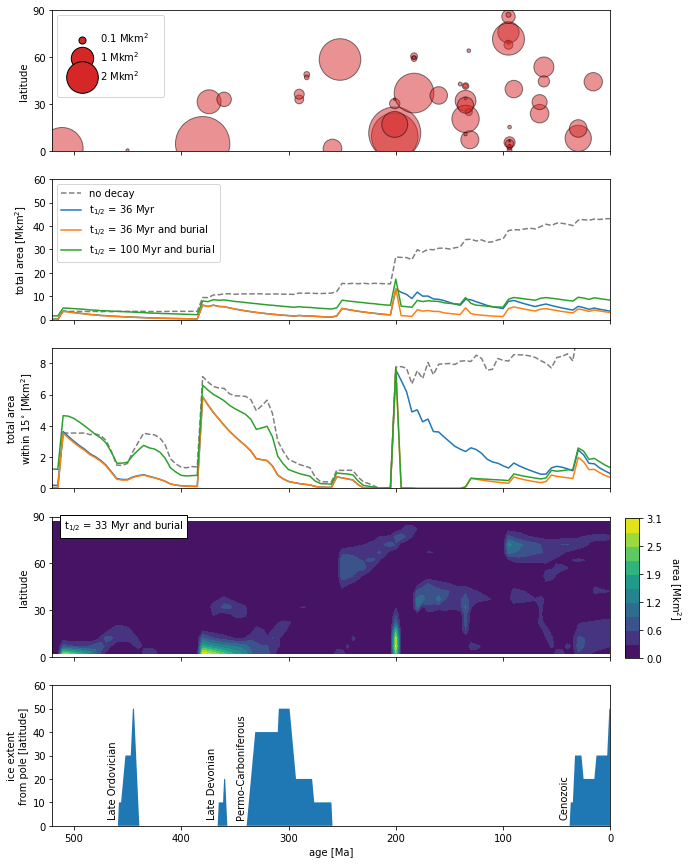

In [47]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,15), sharex=True)

### LIP centroids

scatter_size_ratio = 0.0005
scatter_size = emplacement_area*scatter_size_ratio
ax[0].scatter(emplacement_age, np.abs(emplacement_lat),s=scatter_size,
              facecolor='C3',edgecolor='k',alpha=0.5)
ax[0].set_ylim(0,90)
ax[0].set_yticks([0,30,60,90])
ax[0].set_ylabel('latitude')
l1 = ax[0].scatter([],[], s=100000*scatter_size_ratio, facecolor='C3', edgecolor='k')
l2 = ax[0].scatter([],[], s=1000000*scatter_size_ratio, facecolor='C3', edgecolor='k')
l3 = ax[0].scatter([],[], s=2000000*scatter_size_ratio, facecolor='C3', edgecolor='k')
box = ax[0].get_position()
labels = ['0.1 Mkm$^{2}$', '1 Mkm$^{2}$', '2 Mkm$^{2}$']
ax[0].legend([l1, l2, l3], labels, 
             borderpad=1.5,loc='upper left')

### TOTAL LIPs

ax[1].plot(ts, np.sum(abs_areas_LIPs_df.values[:,3:]/1e6, axis=0) - np.sum(abs_areas_LIPs_df['area_km2_520']/1e6),
           c='C7', ls='--', label='no decay')
ax[1].plot(ts, np.sum(abs_areas_LIPs_decay1_df.values[:,3:]/1e6, axis=0),
           c='C0', label='t$_{1/2}$ = 36 Myr')
ax[1].plot(ts, np.sum(abs_areas_LIPs_cover1_df.values[:,3:]/1e6, axis=0),
           c='C1', label='t$_{1/2}$ = 36 Myr and burial')
ax[1].plot(ts, np.sum(abs_areas_LIPs_cover2_df.values[:,3:]/1e6, axis=0),
           c='C2', label='t$_{1/2}$ = 100 Myr and burial')
ax[1].set_ylim(0,60)
ax[1].set_ylabel('total area [Mkm$^{2}$]')
ax[1].legend()

### TROPICAL LIPs

ax[2].plot(ts, np.sum(abs_areas_LIPs_df.values[:3,3:]/1e6, axis=0),
           c='C7', ls='--', label='no decay')
ax[2].plot(ts, np.sum(abs_areas_LIPs_decay1_df.values[:3,3:]/1e6, axis=0),
           c='C0', label='t$_{1/2}$ = 36 Myr')
ax[2].plot(ts, np.sum(abs_areas_LIPs_cover1_df.values[:3,3:]/1e6, axis=0),
           c='C1', label='t$_{1/2}$ = 36 Myr and burial')
ax[2].plot(ts, np.sum(abs_areas_LIPs_cover2_df.values[:3,3:]/1e6, axis=0),
           c='C2', label='t$_{1/2}$ = 100 Myr and burial')
ax[2].set_ylim(0,9)
ax[2].set_ylabel('total area\nwithin 15$^{\circ}$ [Mkm$^{2}$]')

### HEAT MAP FOR BURIAL + DECAY

values = abs_areas_LIPs_cover1_df.values[:,3:]/1e6
levels = np.linspace(np.min(values),np.max(values),11)
cntrf = ax[3].contourf(ts, abs_areas_LIPs_cover1_df['lat_mids'], values, cmap='viridis', levels=levels)
#cbar_position = fig.add_axes([0.92,0.32,0.02,0.17])
cbar_position = fig.add_axes([0.92,0.28,0.02,0.13])
cbar = fig.colorbar(cntrf, cax=cbar_position)
cbar.set_ticks(np.linspace(np.min(values),np.max(values),6))
cbar.set_ticklabels(np.round(np.linspace(np.min(values),np.max(values),6),1))
cbar.ax.set_ylabel('area [Mkm$^{2}$]', rotation=270, labelpad=20)
ax[3].set_ylabel('latitude')
ax[3].set_yticks([0,30,60,90])
ax[3].text(0.02, 0.93, 't$_{1/2}$ = 33 Myr and burial', bbox=dict(facecolor='white', edgecolor='k'),
           horizontalalignment='left',verticalalignment='center',transform=ax[3].transAxes)

### ICE EXTENT

ax[4].fill_between(ice['AGE (MA)'], ice['LATITUDE FROM POLE'])
ax[4].set_xlabel('age [Ma]')
ax[4].set_ylabel('ice extent\nfrom pole [latitude]')
ax[4].set_ylim(0,60)
ax[4].text(464, 3, 'Late Ordovician', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(371, 3, 'Late Devonian', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(344, 3, 'Permo-Carboniferous', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')
ax[4].text(43, 3, 'Cenozoic', rotation=90,
           horizontalalignment='center',verticalalignment='bottom')

### prettify

ax[4].set_xlim(520,0)

plt.show(fig)

### Table of Data

In [46]:
output_df = pd.DataFrame(columns=['age (Ma)',
                                  'ice extent',
                                  'total',
                                  'within 15',
                                  'decay36 total',
                                  'decay36 within 15',
                                  'decay36_burial total',
                                  'decay36_burial within 15',
                                  'decay100_burial total',
                                  'decay100_burial within 15',
                                  'decay200_burial total',
                                  'decay200_burial within 15'])

output_df['age (Ma)'] = ts

output_df['total'] = np.sum(abs_areas_LIPs_df.values[:,3:], axis=0)
output_df['within 15'] = np.sum(abs_areas_LIPs_df.values[:3,3:], axis=0)

output_df['decay36 total'] = np.sum(abs_areas_LIPs_decay1_df.values[:,3:], axis=0)
output_df['decay36 within 15'] = np.sum(abs_areas_LIPs_decay1_df.values[:3,3:], axis=0)

output_df['decay36_burial total'] = np.sum(abs_areas_LIPs_cover1_df.values[:,3:], axis=0)
output_df['decay36_burial within 15'] = np.sum(abs_areas_LIPs_cover1_df.values[:3,3:], axis=0)

output_df['decay100_burial total'] = np.sum(abs_areas_LIPs_cover2_df.values[:,3:], axis=0)
output_df['decay100_burial within 15'] = np.sum(abs_areas_LIPs_cover2_df.values[:3,3:], axis=0)

output_df['decay200_burial total'] = np.sum(abs_areas_LIPs_cover3_df.values[:,3:], axis=0)
output_df['decay200_burial within 15'] = np.sum(abs_areas_LIPs_cover3_df.values[:3,3:], axis=0)

output_df = output_df[output_df['age (Ma)']<=520]
output_df.reset_index(drop=True, inplace=True)

ts_520 = np.arange(520,-5,-5)
ice_5Myr = np.zeros(len(ts_520))
for i in range(len(ts_520)):
    ice_5Myr[i] = ice[ice['AGE (MA)']==ts_520[i]]['LATITUDE FROM POLE']
output_df['ice extent'] = ice_5Myr

output_df.to_csv('reconstruction_output/summary_output.csv',index=False)

### Centroids

TypeError: nan is not a string

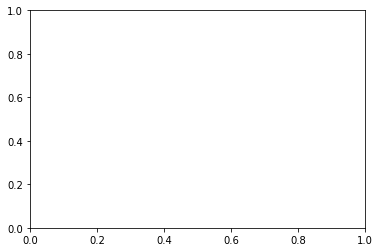

In [45]:
fig, ax = plt.subplots()

for i in range(len(centroid_lat_LIPs_df.index)):
    ax.plot(ts, centroid_lat_LIPs_df.loc[i][1:], c='C0', alpha=0.5)
ax.set_xlabel('emplacement age [Ma]')
ax.set_ylabel('latitude')
ax.invert_xaxis()
ax.set_ylim(-90,90)

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,4))

ax[0].scatter(emplacement_age, emplacement_lat)
ax[0].set_xlabel('emplacement age [Ma]')
ax[0].set_ylabel('latitude')
ax[0].set_ylim(-90,90)

ax[1].scatter(emplacement_age, emplacement_lon)
ax[1].set_xlabel('emplacement age [Ma]')
ax[1].set_ylabel('longitude')
ax[1].set_ylim(-180,180)
ax[1].invert_xaxis()

plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.hist(emplacement_age, bins=20)
ax.set_xlabel('emplacement age [Ma]')
ax.set_ylabel('n')
ax.invert_xaxis()

plt.show()